This notebook includes an analysis covering EDA with a primary focus on understanding variable distributions. Furthermore, it 

incorporates Feature Engineering techniques, encompassing the creation of new features for improved pattern recognition, the 

transformation of existing features to enhance modeling suitability, and the handling of duplicate data and other text 

preprocessing tasks, including vectorization to prepare text for feeding into machine learning models.

# 1. Import Libraries and Reading the Data

In [50]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from contractions import contractions_dict, fix
import spacy
from spacy.lang.en import English

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Utilities
from tqdm import tqdm

# Jupyter Notebook Specific
%matplotlib inline

# Warning Settings
import warnings
warnings.filterwarnings("ignore")

# Pickle for Serialization
import pickle

# spilit data
from sklearn.model_selection import train_test_split


# Vectorization for feature extraction
from sklearn.feature_extraction.text import CountVectorizer #converting a collection of text doc to a matrix of token counts.

In [4]:
## Reading the data

data = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/Reviews.csv')
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## 2. EDA

### Data Understanding

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Check missing values

In [7]:
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

### Check duplicate data

In [8]:
# filtered_data = data.drop(columns=['ProductId'])
duplicate_entry = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
duplicate_entry.shape

(232415, 10)

In [9]:
duplicate_entry.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
68,69,B000E7VI7S,A1KL2LAW08X6UQ,calmnsense,0,0,3,1169251200,How much would you pay for a bag of chocolate ...,"If you're impulsive like me, then $6 is ok. Do..."
69,70,B000E7VI7S,AWCBF2ZWIN57F,C. Salcido,0,2,5,1185753600,pretzel haven!,this was sooooo deliscious but too bad i ate e...


### Drop Duplicated data

- During basic data cleaning, we identified redundant entries where users provided the same review for different products simultaneously. To address this, we'll keep only the first occurrence and remove subsequent duplicates.

In [10]:
data.shape  # original dataset

(568454, 10)

In [11]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

In [12]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((df.shape[0]*1.0)/(data.shape[0]*1.0))*100}')

Remaining data is 69.29901100176971


- Now our data points got reduced to about 69%.

In [13]:
print(df.duplicated().value_counts())

False    393933
dtype: int64


## 3.Feature Engineering

- Create new columnns **"usefulness"** by analyzing "HelpfulnessNumerator" and "HelpfulnessDenominator"

- What are the differences?
    
    
- HelpfulnessNumerator = Represent the number of people who found the review helpful.


- HelpfulnessDenominator = Represent the number of people who found the review, whether they found it j´helpful or not.

In [15]:
df['usefulness'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
df.usefulness[105:110] # randomly check the values

106    0.25
107    1.00
108    1.00
109     NaN
110    1.00
Name: usefulness, dtype: float64

>> Categorized the "usefulness" based on certain conditions

- If the value is greater than 0.75, it appends ">75%" to the 'usefulness' list.


- If the value is less than 0.25, it appends "<25%" to the 'usefulness' list.


- If the value is between 0.25 and 0.75 (inclusive), it appends "25-75%" to the 'usefulness' list.


- If none of the above conditions are met, it appends "useless" to the 'usefulness' list.

In [16]:
usefulness = [] # this columns convert from float to object
for i in df['usefulness']:
    if i > 0.75:
        usefulness.append(">75%")
    elif i < 0.25:
        usefulness.append("<25%")
    elif i >= 0.25 and i <= 0.75:
        usefulness.append("25-75%")
    else:
        usefulness.append("useless")
df['usefulness']  = usefulness  

In [17]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'usefulness'],
      dtype='object')

### Distribution of usefulness

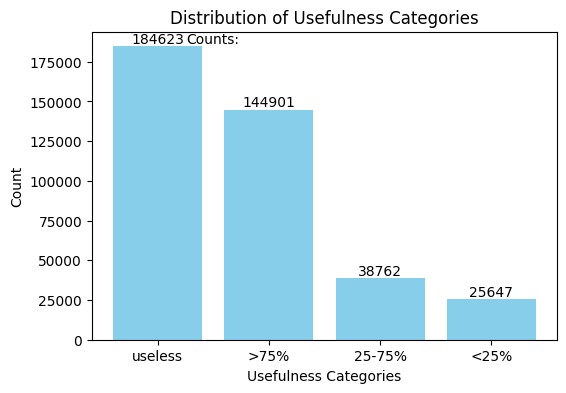

In [18]:
category_counts = df['usefulness'].value_counts() # usefulness categorical

# Plotting with adjustments
plt.figure(figsize=(6, 4)) 
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Usefulness Categories')
plt.ylabel('Count')
plt.title('Distribution of Usefulness Categories')
plt.text(0.5, max(category_counts.values) + 5, 'Counts:', horizontalalignment='center', verticalalignment='bottom', fontsize=10)
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 2, str(count), horizontalalignment='center', verticalalignment='bottom', fontsize=10)

plt.show()

- provides a comparative analysis of 'usefulness' within different 'Score' categories using a specialized count plot

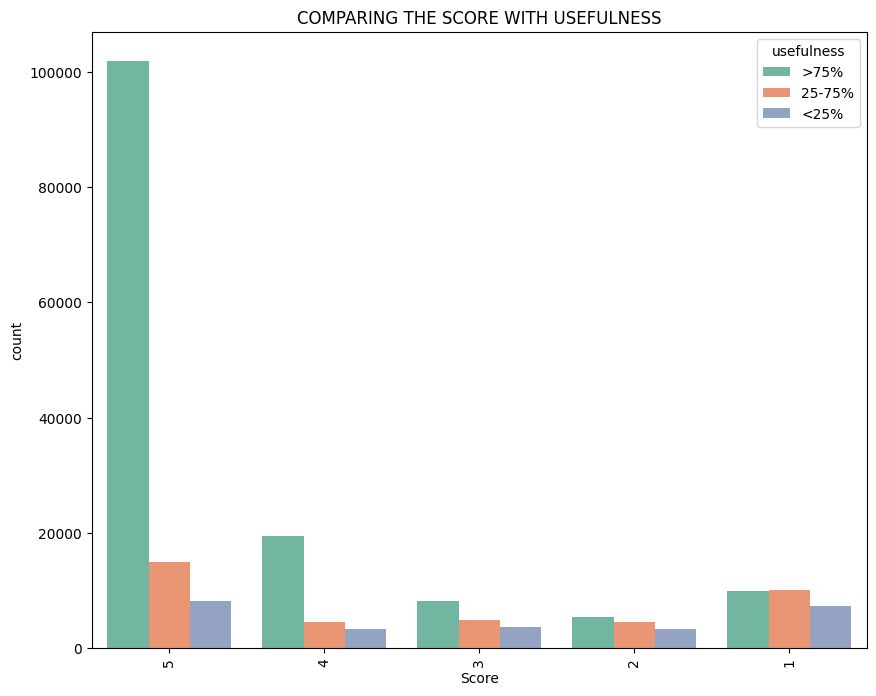

In [19]:
plt.figure(figsize=(10,8))
sns.countplot(x='Score',data=df,hue='usefulness',hue_order=['>75%','25-75%','<25%'],order=[5,4,3,2,1],palette="Set2")
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

- Create a new column **'word_count'** containing the word count for each review text. This can be useful for analyzing and understanding the length or complexity of the reviews in terms of the number of words.

In [20]:
word_count = []
for i in df['Text']:
    word_count.append(len(i.split()))
df['word_count'] = word_count    

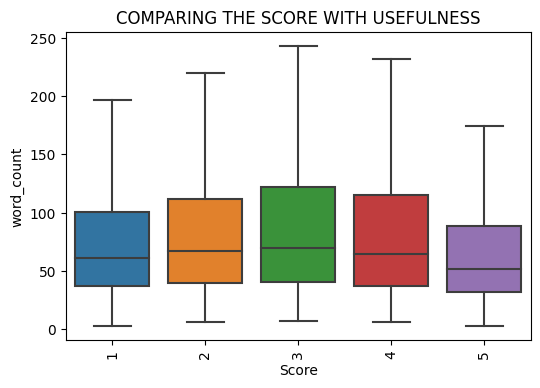

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Score',y='word_count',data=df,showfliers=False)
plt.xticks(rotation=90,fontsize=10)
plt.title('COMPARING THE SCORE WITH USEFULNESS')
plt.show()

###  Count of Reviews by stars

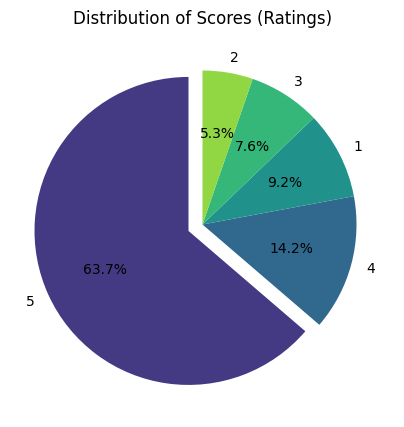

In [22]:
# Assuming 'Score' is the column containing ratings in your DataFrame
plt.figure(figsize=(5, 5))

# Sort the DataFrame by 'Score'
df_sorted = df.sort_values(by='Score')

# Define a custom color palette
custom_palette = sns.color_palette("viridis", n_colors=len(df_sorted['Score'].unique()))

score_counts = df_sorted['Score'].value_counts()
labels = score_counts.index
explode = (0.1, 0, 0, 0, 0)  # Explode the first slice (optional)

plt.pie(score_counts, labels=labels, colors=custom_palette, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of Scores (Ratings)')
plt.show()



- Create new columns **"Sentiment"** based on the values in the existing 'Score' columns. The logic is a s follows:
    
    
    - If the 'Score' is greater than 3, the corresponding sentiment is set to 'positive'.
    
    
    - If the 'Score' is less than 3, the sentiment is set to 'negative'.
    
    
    - If the 'Score' is exactly 3, the sentiment is set to 'not'.
    

In [23]:
sentiment = []
for i in df['Score']:
    if i > 3:
        sentiment.append('positive')
    elif i < 3:
        sentiment.append('negative')
    else:
        sentiment.append('not')
df['sentiment'] = sentiment   

In [24]:
df.sentiment.head()

0    positive
1    negative
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [25]:
positive_rev = df[df.sentiment=='positive']
positive_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,>75%,48,positive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,>75%,94,positive


In [26]:
Negative_rev = df[df.sentiment=='negative']
Negative_rev.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,usefulness,word_count,sentiment
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,useless,31,negative
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,>75%,41,negative


**WordCloud Class**:


The WordCloud class from the wordcloud library generates visual representations of text data, sizing words based on frequency. It allows customization of parameters like image size, color schemes, and fonts.


**STOPWORDS**:

STOPWORDS, a set of common words (e.g., "the," "and," "is"), are often excluded in text analysis as they contribute little meaning. In WordCloud, the stopwords parameter excludes specific words from the generated word cloud.

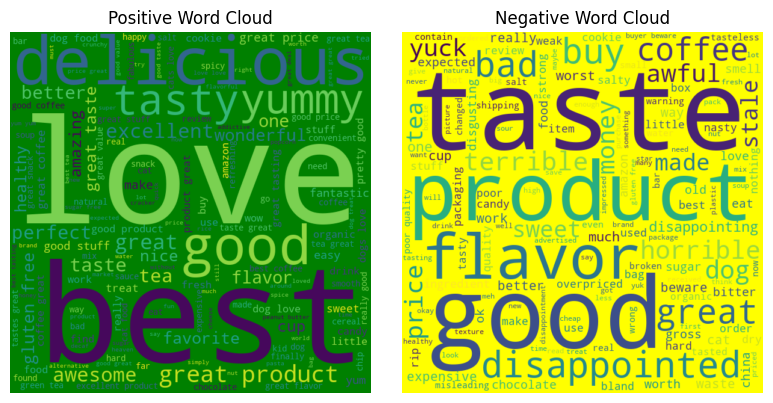

In [27]:
# Positive Word Cloud
comment_words_positive = ''
stopwords = set(STOPWORDS)

for val in positive_rev['Summary']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words_positive += " ".join(tokens) + " "

wordcloud_positive = WordCloud(width=600, height=600,
                               background_color='green',
                               stopwords=stopwords,
                               min_font_size=10).generate(comment_words_positive)

# Negative Word Cloud
comment_words_negative = ''
for val in Negative_rev['Summary']:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words_negative += " ".join(tokens) + " "

wordcloud_negative = WordCloud(width=600, height=600,
                               background_color='yellow',
                               stopwords=stopwords,
                               min_font_size=10).generate(comment_words_negative)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Positive Word Cloud
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Positive Word Cloud')
axes[0].axis('off')

# Negative Word Cloud
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Negative Word Cloud')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4.Preprocessing the Text Data

 - Initiate by eliminating HTML tags.
 
 
 - Remove any punctuations or a limited set of special characters such as commas, periods, hashtags, etc.
 
 
 - Verify if the word consists of English letters and is not alphanumeric.
 
 
 - Validate that the length of the word exceeds 2 characters, as research indicates the absence of adjectives in 2-letter words.
 
 
 - Convert the word to lowercase.
 
 
 - Eliminate stopwords.

In [32]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tmost\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
from nltk.corpus import stopwords

# Use a different name for the set of stopwords
stopwords_set = set(stopwords.words('english'))

def decontracted(phrase):
    # Use contractions.fix from the contractions library
    return fix(phrase)

preprocessed_reviews = []

# tqdm is for printing the status bar
for sentence in tqdm(df['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    # removing html tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    # removing extra spaces and numbers
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    # removing non-alphabetic characters
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # Tokenize and remove stop words using NLTK
    words = word_tokenize(sentence)
    sentence = ' '.join(e.lower() for e in words if e.lower() not in stopwords_set)
    preprocessed_reviews.append(sentence.strip())


100%|█████████████████████████████████████████████████████████████████████████| 393933/393933 [06:51<00:00, 958.43it/s]


## 5. Clean Text

- Now creates a new column named 'clean_text' in the DataFrame df and assigns the values from the preprocessed_reviews list to this column. The preprocessed_reviews list seems to contain preprocessed text data, possibly cleaned and tokenized.


- then reorders the columns in the DataFrame, selecting only the 'Time', 'clean_text', and 'Score' columns and updating the DataFrame with this new selection.

In [35]:
#combining required columns
df['clean_text'] = preprocessed_reviews
df = df[['Time','clean_text','Score']]
#reseting index
df = df.reset_index(drop=True) # The drop=True parameter is used to discard the old index column.
#saving processed file
df.to_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df.csv',index=False)

In [36]:
# Reading the preprocessed file
df = pd.read_csv('C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis/processed_df.csv')
print(df.shape)
df.head()

(393933, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,5
1,1346976000,product arrived labeled jumbo salted peanuts p...,1
2,1219017600,confection around centuries light pillowy citr...,4
3,1307923200,looking secret ingredient robitussin believe f...,2
4,1350777600,great taffy great price wide assortment yummy ...,5


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393933 entries, 0 to 393932
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        393933 non-null  int64 
 1   clean_text  392917 non-null  object
 2   Score       393933 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.0+ MB


In [38]:
df.clean_text.isnull().any()

True

In [39]:
missing_indices = df[df['clean_text'].isnull()].index
print(missing_indices)

Int64Index([   711,    833,   1057,   1343,   2029,   2301,   2502,   2655,
              2672,   2880,
            ...
            390645, 391711, 392132, 392141, 392351, 392474, 392711, 392862,
            393077, 393797],
           dtype='int64', length=1016)


In [40]:
#one row is empty.we will drop it
df = df.dropna(axis=0)
df.shape

(392917, 3)

In [41]:
df.isnull().any()

Time          False
clean_text    False
Score         False
dtype: bool

Analyzing text data over time is crucial for gaining insights into evolving patterns, sentiments, and user behaviors. Time provides context for understanding temporal trends, seasonal variations, and the impact of events on language. It also allows for the detection of linguistic shifts, user sentiment changes, and the dynamic evolution of terms. Incorporating a temporal perspective in text analysis enables more accurate predictions, cohort analysis, and a nuanced understanding of how language and sentiments adapt to changing circumstances.

In [ ]:
- We are considering time beacuse our reviews are developed over time, so splitting based on that makes more sense

In [42]:
 df = df.sample(100000,random_state=42)

In [43]:
df.shape

(100000, 3)

In [44]:
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)

## 6. Splitting data

- Train test split
Once we are done with preprocessing, we will split our data into train and test. We will do splitting after sorting the data based on time as a change in time can influence the reviews.

In [46]:
x = df['clean_text']
y = df['Score']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=42)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (70000,)
shape of X_test is (30000,)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [55]:
import os

# Specify the full path for the directory
directory_path = 'C:/Users/tmost/Documents/Data-course/NLP_SemanticAnalysis'
os.makedirs(directory_path + '/saved_feats', exist_ok=True)

In [56]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)

## 7. Vectorization

**Vectorization** in the context of NLP refers to the process of converting textual data into numerical vectors. It's a crucial step in preparing text data for ML algorithms. Vectorization allows us to represent words, sentences, or documents as numerical vectors, enabling machines to process and analyze textual information.

There are several methods for text vectorization in NLP, such as 

1. Bag_of_Words


2. Term Frequency-Inverse Document Frequency (TF-IDF)


3. Word Embeddings (Word Vectors)


4. Doc2Vec (Paragraph Vectors)


5. Hashing Vectorizer

It's common to experiment with multiple methods to find the one that works best for the  sentiment analysis problem.

but we can start with simplicity: Begin with Bag-of-Words or TF-IDF, especially if our dataset is not extremely large. These methods are simple and can provide good results for sentiment analysis tasks.

# Bag of Words (bow)

In [57]:
bow = CountVectorizer() # entire vocabulary
bow.fit(X_train) 
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (70000, 50778)
shape of X_test_bow is (30000, 50778)


In [59]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

## Loading saved vectors

In [60]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


shape of X_train_bow is (70000, 50778)
shape of X_test_bow is (30000, 50778)
